In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda


In [2]:
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_path = '/mnt/d/WSL/ubuntu/dataset/AcneV86/train/images'
val_path = '/mnt/d/WSL/ubuntu/dataset/AcneV86/valid/images'
test_path = '/mnt/d/WSL/ubuntu/dataset/AcneV86/test/images'

data_yaml_path = '/mnt/d/WSL/ubuntu/dataset/AcneV86/data.yaml'

In [4]:
import os
# Fungsi untuk menghitung jumlah file gambar dalam folder
def count_images_in_folder(folder_path):
    if os.path.exists(folder_path):
        return len([file for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png', '.jpeg'))])
    return 0

# Hitung jumlah data
num_train = count_images_in_folder(train_path)
num_val = count_images_in_folder(val_path)
num_test = count_images_in_folder(test_path)
total_data = num_train + num_val + num_test

# Tampilkan hasil
print(f"Total data: {total_data}")
print(f"Jumlah data train: {num_train}")
print(f"Jumlah data validasi: {num_val}")
print(f"Jumlah data test: {num_test}")

Total data: 2008
Jumlah data train: 1758
Jumlah data validasi: 164
Jumlah data test: 86



--- Analyzing Object Counts per Class ---
Found 3 classes: ['blackhead', 'fungal', 'nodule']
Processing labels in '/mnt/d/WSL/ubuntu/dataset/AcneV86/train/labels'...

Object Count Statistics for Training Set:
  Class Name  Count
0  blackhead  11324
2     nodule   1278
1     fungal    684

Total Objects across all classes in Training Set: 13286


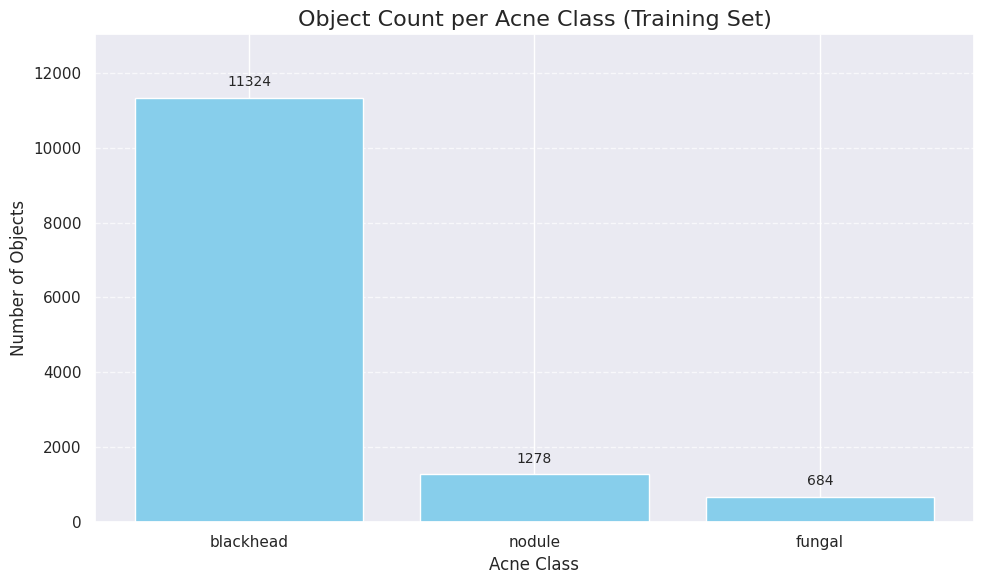

In [5]:
import yaml
from collections import defaultdict
import numpy as np # Diperlukan untuk warna dinamis

# Mendapatkan root path dataset dari data_yaml_path
# Ini akan mengambil '/mnt/d/WSL/ubuntu/dataset/AcneV85/'
dataset_root_path = os.path.dirname(data_yaml_path)

# --- Fungsi untuk membaca data.yaml ---
def load_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

# --- Fungsi untuk menghitung objek dari file anotasi ---
def count_classes_in_labels(labels_dir, class_counts):
    if not os.path.exists(labels_dir):
        # print(f"Label directory '{labels_dir}' not found, skipping.") # Opsional: uncomment untuk debug
        return class_counts
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            filepath = os.path.join(labels_dir, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    # Setiap baris di file TXT anotasi YOLO dimulai dengan Class ID
                    try:
                        class_id = int(line.split(' ')[0])
                        class_counts[class_id] += 1
                    except (ValueError, IndexError):
                        print(f"Warning: Could not parse line in {filepath}: {line.strip()}")
    return class_counts

# --- Main Logic untuk Class Count ---
print("\n--- Analyzing Object Counts per Class ---")
try:
    # 1. Baca data.yaml untuk mendapatkan nama kelas
    data_config = load_yaml(data_yaml_path)

    if 'names' not in data_config:
        raise ValueError(f"'names' key not found in {data_yaml_path}. Please check your data.yaml structure.")

    class_names_map = {i: name for i, name in enumerate(data_config['names'])}
    num_classes = len(class_names_map)
    print(f"Found {num_classes} classes: {list(class_names_map.values())}")

    # Inisialisasi class_counts
    class_counts_raw = defaultdict(int)

    # 2. Iterasi dan hitung objek di semua set (train, valid, test)
    sets_to_process = ['train']
    for s in sets_to_process:
        labels_dir = os.path.join(dataset_root_path, s, 'labels')
        print(f"Processing labels in '{labels_dir}'...")
        class_counts_raw = count_classes_in_labels(labels_dir, class_counts_raw)

    # Konversi hasil hitungan ke format yang mudah divisualisasikan
    final_class_counts = []
    final_class_names = []
    for class_id in sorted(class_counts_raw.keys()):
        if class_id in class_names_map:
            final_class_names.append(class_names_map[class_id])
            final_class_counts.append(class_counts_raw[class_id])
        else:
            print(f"Warning: Class ID {class_id} found in labels but not in data.yaml. This class will be skipped.")

    if not final_class_counts:
        print("No objects found in the training set. Please ensure the dataset path and folder structure are correct, and annotation files contain class IDs.")
        exit()

    # Membuat DataFrame untuk visualisasi
    df_class_counts = pd.DataFrame({
        'Class Name': final_class_names,
        'Count': final_class_counts
    })

    df_class_counts = df_class_counts.sort_values(by='Count', ascending=False)
    print("\nObject Count Statistics for Training Set:")
    print(df_class_counts)
    print(f"\nTotal Objects across all classes in Training Set: {df_class_counts['Count'].sum()}")

    # --- Visualisasi (Bar Chart) ---
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_class_counts['Class Name'], df_class_counts['Count'], color='skyblue')

    plt.title('Object Count per Acne Class (Training Set)', fontsize=16) # Ubah judul
    plt.xlabel('Acne Class', fontsize=12)
    plt.ylabel('Number of Objects', fontsize=12)
    plt.xticks(rotation=0)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (max(df_class_counts['Count'])*0.02),
                 f'{yval}', ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(df_class_counts['Count']) * 1.15)
    plt.tight_layout()
    plt.show()

    # # --- Visualisasi (Pie Chart) ---
    # plt.figure(figsize=(8, 8))
    # plt.pie(df_class_counts['Count'], labels=df_class_counts['Class Name'], autopct='%1.1f%%', startangle=90,
    #         colors=colors, pctdistance=0.85)
    # plt.title('Proportion of Objects per Acne Class (Training Set)', fontsize=16) # Ubah judul
    # plt.axis('equal')
    # plt.tight_layout()
    # plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure your dataset directory structure is correct (e.g., 'train/labels' relative to the data.yaml parent directory).")
except yaml.YAMLError:
    print(f"Error: Failed to read YAML file at '{data_yaml_path}'. Please ensure its format is correct.")
except Exception as e:
    print(f"An unexpected error occurred during class counting or plotting: {e}")


In [6]:
model = YOLO('yolov8n.pt')

model.train(
    data=data_yaml_path,
    epochs=150,
    batch=16,
    imgsz=640,
    device=0,
    patience=50,
    name='V86n-150'
)

New https://pypi.org/project/ultralytics/8.3.145 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.133 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/mnt/d/WSL/ubuntu/dataset/AcneV86/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=V86n-150, nbs=

train: Scanning /mnt/d/WSL/ubuntu/dataset/AcneV86/train/labels.cache... 1758 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1758/1758 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 4.4±1.3 ms, read: 5.6±2.5 MB/s, size: 33.7 KB)


val: Scanning /mnt/d/WSL/ubuntu/dataset/AcneV86/valid/labels.cache... 164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<?, ?it/s]


Plotting labels to runs/detect/V86n-150/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/V86n-150
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.69G       2.15      3.191      1.621         94        640: 100%|██████████| 110/110 [00:26<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


                   all        164       1507      0.236     0.0769     0.0871     0.0277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      3.17G       2.08      2.498      1.542         56        640: 100%|██████████| 110/110 [00:16<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

                   all        164       1507      0.249      0.247      0.176     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      3.76G      2.065      2.261      1.533         56        640: 100%|██████████| 110/110 [00:16<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]

                   all        164       1507      0.329      0.207      0.165       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      3.78G      2.048      2.092      1.492        108        640: 100%|██████████| 110/110 [00:15<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]

                   all        164       1507      0.256      0.287      0.198     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      3.78G      2.024      2.051      1.502        482        640: 100%|██████████| 110/110 [00:16<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.04it/s]

                   all        164       1507      0.368      0.398      0.274        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150       3.8G      1.972      1.933      1.457        105        640: 100%|██████████| 110/110 [00:16<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]

                   all        164       1507      0.417      0.398      0.329      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150       3.8G      1.936      1.861      1.449        102        640: 100%|██████████| 110/110 [00:16<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]

                   all        164       1507      0.395      0.427      0.339      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      3.81G      1.909      1.775       1.42        167        640: 100%|██████████| 110/110 [00:16<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all        164       1507       0.61      0.266      0.296     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      3.81G      1.902      1.791      1.424         65        640: 100%|██████████| 110/110 [00:15<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all        164       1507      0.481      0.438        0.4      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      3.83G      1.893      1.751      1.386         81        640: 100%|██████████| 110/110 [00:16<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all        164       1507      0.407      0.407      0.352      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      3.83G      1.831      1.734      1.422        164        640: 100%|██████████| 110/110 [00:15<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]

                   all        164       1507      0.477      0.422      0.398      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      3.83G      1.864      1.749       1.41        209        640: 100%|██████████| 110/110 [00:16<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]

                   all        164       1507      0.422      0.446      0.356      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      3.83G       1.88      1.682      1.361        286        640: 100%|██████████| 110/110 [00:15<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        164       1507      0.514      0.467      0.444      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      3.83G      1.835      1.652       1.39        165        640: 100%|██████████| 110/110 [00:15<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]

                   all        164       1507      0.504      0.392      0.412      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      3.83G      1.823      1.636      1.373         79        640: 100%|██████████| 110/110 [00:16<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all        164       1507      0.552      0.433       0.43      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      3.83G      1.819      1.611      1.367        184        640: 100%|██████████| 110/110 [00:15<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all        164       1507      0.543      0.426      0.428      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      3.83G      1.806      1.585      1.329        179        640: 100%|██████████| 110/110 [00:16<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all        164       1507      0.524      0.454      0.424      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      3.83G      1.759       1.57      1.353         48        640: 100%|██████████| 110/110 [00:15<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all        164       1507      0.492      0.481      0.432      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      3.83G      1.804      1.534      1.333        303        640: 100%|██████████| 110/110 [00:16<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]

                   all        164       1507      0.505      0.432      0.412      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      3.83G      1.769      1.526       1.33         96        640: 100%|██████████| 110/110 [00:15<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all        164       1507      0.501      0.426      0.424      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      3.83G      1.763      1.483      1.332         51        640: 100%|██████████| 110/110 [00:16<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]

                   all        164       1507      0.557       0.41      0.441       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      3.83G      1.743      1.489      1.323        148        640: 100%|██████████| 110/110 [00:15<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

                   all        164       1507      0.561      0.464      0.498      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      3.83G      1.767      1.482      1.301         78        640: 100%|██████████| 110/110 [00:16<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]

                   all        164       1507      0.566      0.511        0.5      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      3.83G      1.723      1.447      1.304         97        640: 100%|██████████| 110/110 [00:15<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        164       1507      0.577      0.528      0.514      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      3.83G      1.721      1.452      1.308         84        640: 100%|██████████| 110/110 [00:15<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all        164       1507      0.564      0.491      0.517       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      3.83G      1.737      1.445      1.315         68        640: 100%|██████████| 110/110 [00:16<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all        164       1507      0.566      0.438      0.469        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      3.83G      1.726      1.424      1.289        195        640: 100%|██████████| 110/110 [00:15<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all        164       1507      0.591      0.498      0.479      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      3.83G      1.708      1.433      1.301        104        640: 100%|██████████| 110/110 [00:16<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        164       1507      0.598      0.522      0.503      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      3.83G      1.674      1.381      1.306        189        640: 100%|██████████| 110/110 [00:15<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]

                   all        164       1507      0.578      0.441      0.483      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      3.83G      1.672      1.359      1.292        191        640: 100%|██████████| 110/110 [00:16<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

                   all        164       1507      0.563      0.477      0.472      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      3.83G      1.677      1.364      1.291        255        640: 100%|██████████| 110/110 [00:15<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

                   all        164       1507       0.66      0.497      0.511      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      3.83G      1.664      1.339      1.284        113        640: 100%|██████████| 110/110 [00:15<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.92it/s]

                   all        164       1507      0.586      0.532      0.522      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      3.83G      1.665      1.351       1.28        120        640: 100%|██████████| 110/110 [00:16<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all        164       1507      0.618      0.475      0.532      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      3.83G      1.674      1.326       1.27        230        640: 100%|██████████| 110/110 [00:15<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all        164       1507      0.593      0.488       0.54      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      3.83G      1.671      1.306      1.263        201        640: 100%|██████████| 110/110 [00:16<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all        164       1507      0.517      0.454      0.456       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      3.83G      1.659      1.308      1.273         75        640: 100%|██████████| 110/110 [00:15<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]

                   all        164       1507      0.509      0.495      0.472      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      3.83G      1.658       1.29      1.272        226        640: 100%|██████████| 110/110 [00:16<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all        164       1507      0.647      0.547      0.556      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      4.55G      1.652      1.286      1.235        196        640: 100%|██████████| 110/110 [00:15<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

                   all        164       1507      0.621      0.486      0.489      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      3.14G      1.656      1.293      1.255         93        640: 100%|██████████| 110/110 [00:16<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all        164       1507      0.566      0.478      0.459      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      3.28G      1.628      1.294       1.27         75        640: 100%|██████████| 110/110 [00:14<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

                   all        164       1507      0.604      0.493      0.508      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      3.82G       1.65       1.26      1.239        191        640: 100%|██████████| 110/110 [00:15<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.54it/s]

                   all        164       1507      0.555      0.551       0.52      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      3.89G      1.604       1.21      1.225        128        640: 100%|██████████| 110/110 [00:15<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all        164       1507      0.596      0.472      0.508      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      3.29G      1.621       1.24      1.235         72        640: 100%|██████████| 110/110 [00:15<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all        164       1507      0.609      0.511      0.542       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      3.89G      1.604      1.212      1.238         85        640: 100%|██████████| 110/110 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]

                   all        164       1507      0.544      0.436      0.442       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      4.56G        1.6      1.201      1.227        223        640: 100%|██████████| 110/110 [00:15<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]

                   all        164       1507      0.559      0.549      0.535      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      3.24G      1.584      1.178      1.219        230        640: 100%|██████████| 110/110 [00:15<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]

                   all        164       1507       0.68      0.501      0.547      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      3.86G      1.608      1.184      1.211         97        640: 100%|██████████| 110/110 [00:15<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

                   all        164       1507      0.665      0.433      0.503      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      3.64G      1.582      1.163      1.203         94        640: 100%|██████████| 110/110 [00:16<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all        164       1507      0.573      0.454      0.462      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      3.34G      1.618       1.18      1.215        183        640: 100%|██████████| 110/110 [00:15<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all        164       1507      0.607      0.503      0.517      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      3.29G      1.588      1.171      1.209         92        640: 100%|██████████| 110/110 [00:15<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all        164       1507       0.59      0.556      0.544      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      3.33G      1.571       1.15      1.216        144        640: 100%|██████████| 110/110 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]

                   all        164       1507      0.583      0.489      0.493      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      3.93G      1.569      1.147      1.204         85        640: 100%|██████████| 110/110 [00:15<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

                   all        164       1507      0.648      0.547      0.557      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      3.95G      1.567      1.132      1.204        214        640: 100%|██████████| 110/110 [00:16<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]

                   all        164       1507      0.699      0.516      0.582      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      3.95G      1.527      1.097      1.195         85        640: 100%|██████████| 110/110 [00:15<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all        164       1507      0.627      0.479       0.51      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      3.96G      1.534      1.103      1.196         48        640: 100%|██████████| 110/110 [00:16<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

                   all        164       1507       0.65      0.535      0.566      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      3.96G      1.519      1.096      1.187        223        640: 100%|██████████| 110/110 [00:16<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]

                   all        164       1507      0.646      0.505      0.533      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      3.98G      1.525      1.079      1.176         89        640: 100%|██████████| 110/110 [00:16<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all        164       1507      0.571      0.508      0.515      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      3.98G       1.52      1.091      1.192        165        640: 100%|██████████| 110/110 [00:15<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all        164       1507      0.638      0.431      0.495      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150         4G      1.534      1.097      1.181        219        640: 100%|██████████| 110/110 [00:16<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.06it/s]

                   all        164       1507      0.559      0.546      0.528      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150         4G      1.542      1.081      1.178        126        640: 100%|██████████| 110/110 [00:16<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]

                   all        164       1507      0.625      0.513      0.512       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150         4G      1.503      1.063      1.189        112        640: 100%|██████████| 110/110 [00:15<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all        164       1507      0.658      0.518       0.56      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150         4G       1.52      1.068      1.177        112        640: 100%|██████████| 110/110 [00:16<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all        164       1507      0.617      0.551      0.556      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150         4G      1.521      1.052      1.181        265        640: 100%|██████████| 110/110 [00:15<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]

                   all        164       1507      0.619       0.48      0.511      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150         4G      1.496      1.035      1.182        364        640: 100%|██████████| 110/110 [00:16<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all        164       1507      0.611      0.532      0.518      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150         4G      1.514      1.034      1.172        144        640: 100%|██████████| 110/110 [00:15<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]

                   all        164       1507      0.569      0.506      0.513      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150         4G       1.48      1.017      1.161         66        640: 100%|██████████| 110/110 [00:16<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        164       1507      0.622      0.521      0.524      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150         4G      1.491      1.027      1.174         70        640: 100%|██████████| 110/110 [00:15<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]

                   all        164       1507      0.626      0.515      0.533      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150         4G      1.477       1.02      1.164        153        640: 100%|██████████| 110/110 [00:15<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all        164       1507      0.689      0.525      0.555      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150         4G      1.436      1.005      1.171         69        640: 100%|██████████| 110/110 [00:16<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all        164       1507        0.6       0.48      0.473      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150         4G      1.454     0.9822       1.15         69        640: 100%|██████████| 110/110 [00:15<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all        164       1507      0.574      0.567      0.541       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150         4G      1.478     0.9934      1.147        247        640: 100%|██████████| 110/110 [00:16<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]

                   all        164       1507      0.623      0.513      0.524       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150         4G      1.487      1.003      1.156        191        640: 100%|██████████| 110/110 [00:15<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]

                   all        164       1507      0.559      0.542      0.525      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150         4G       1.46      0.977      1.146        233        640: 100%|██████████| 110/110 [00:16<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all        164       1507      0.622      0.513      0.505      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150         4G       1.44     0.9649      1.142         64        640: 100%|██████████| 110/110 [00:15<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all        164       1507      0.629      0.572      0.586      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150         4G      1.437     0.9881      1.162        104        640: 100%|██████████| 110/110 [00:16<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all        164       1507      0.609      0.513      0.529      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      4.63G      1.453     0.9766      1.146        122        640: 100%|██████████| 110/110 [00:15<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

                   all        164       1507      0.558      0.523      0.513      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      3.92G      1.439     0.9722      1.148        195        640: 100%|██████████| 110/110 [00:15<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]

                   all        164       1507      0.608      0.546      0.549      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.84G      1.435     0.9607      1.143        250        640: 100%|██████████| 110/110 [00:16<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]

                   all        164       1507      0.662      0.508      0.545      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      3.71G      1.422     0.9478       1.14         74        640: 100%|██████████| 110/110 [00:15<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]

                   all        164       1507      0.574      0.502      0.507      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      3.73G      1.419     0.9598      1.145        169        640: 100%|██████████| 110/110 [00:16<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]

                   all        164       1507      0.595      0.514      0.525      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      3.73G      1.423     0.9411       1.12        111        640: 100%|██████████| 110/110 [00:15<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all        164       1507      0.663      0.488      0.521      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      4.92G       1.41     0.9237       1.12        183        640: 100%|██████████| 110/110 [00:16<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]

                   all        164       1507      0.637      0.538      0.575      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      3.58G      1.394     0.9121      1.114        130        640: 100%|██████████| 110/110 [00:15<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

                   all        164       1507      0.619      0.509       0.54      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      3.41G      1.394     0.9143      1.112         63        640: 100%|██████████| 110/110 [00:15<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all        164       1507      0.578      0.519      0.544      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150         4G      1.411     0.9256      1.131         94        640: 100%|██████████| 110/110 [00:15<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all        164       1507      0.691       0.52       0.57      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      3.42G      1.373     0.8989       1.13         95        640: 100%|██████████| 110/110 [00:14<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all        164       1507      0.606      0.507      0.546      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      3.26G      1.392     0.9111      1.118        129        640: 100%|██████████| 110/110 [00:16<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        164       1507      0.656      0.533      0.565      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      3.48G      1.378     0.9119      1.118         37        640: 100%|██████████| 110/110 [00:15<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]

                   all        164       1507       0.61       0.49      0.533      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      3.59G       1.35     0.8763       1.12        118        640: 100%|██████████| 110/110 [00:16<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all        164       1507      0.663      0.528      0.563      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      3.98G      1.344     0.8655      1.105        135        640: 100%|██████████| 110/110 [00:15<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all        164       1507      0.582      0.511      0.536      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      3.52G      1.359     0.8628       1.12        156        640: 100%|██████████| 110/110 [00:15<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all        164       1507      0.616      0.532       0.55      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      4.15G      1.371     0.8849      1.118        127        640: 100%|██████████| 110/110 [00:15<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

                   all        164       1507      0.578      0.545      0.543      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      3.55G      1.345     0.8516      1.096        142        640: 100%|██████████| 110/110 [00:16<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all        164       1507      0.649      0.511      0.555      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      3.83G      1.347     0.8615      1.102        111        640: 100%|██████████| 110/110 [00:15<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all        164       1507      0.624      0.528      0.546      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      3.14G      1.335     0.8559      1.113        109        640: 100%|██████████| 110/110 [00:15<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 12.53it/s]

                   all        164       1507      0.663      0.516      0.537      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      3.79G      1.355     0.8629      1.101        255        640: 100%|██████████| 110/110 [00:16<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all        164       1507      0.597      0.542      0.526      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      3.42G       1.32     0.8333       1.09        218        640: 100%|██████████| 110/110 [00:15<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all        164       1507      0.704      0.501      0.542      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      3.97G      1.318     0.8352      1.091         81        640: 100%|██████████| 110/110 [00:16<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]

                   all        164       1507      0.634       0.51       0.54      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      4.82G      1.351      0.856        1.1        147        640: 100%|██████████| 110/110 [00:15<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]

                   all        164       1507      0.651      0.531      0.556      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      3.98G      1.337     0.8381      1.086         96        640: 100%|██████████| 110/110 [00:16<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        164       1507      0.618      0.543      0.553      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150         4G       1.33     0.8368       1.08        188        640: 100%|██████████| 110/110 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

                   all        164       1507      0.595      0.516      0.522      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      4.15G      1.297     0.8181      1.092         94        640: 100%|██████████| 110/110 [00:16<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all        164       1507      0.637      0.514      0.544      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      3.24G      1.299     0.8155      1.066        180        640: 100%|██████████| 110/110 [00:15<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

                   all        164       1507      0.607      0.522      0.531      0.241
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 53, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



103 epochs completed in 0.505 hours.
Optimizer stripped from runs/detect/V86n-150/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/V86n-150/weights/best.pt, 6.3MB

Validating runs/detect/V86n-150/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


                   all        164       1507      0.693      0.513      0.582      0.256
             blackhead         55       1319      0.591      0.287      0.367      0.137
                fungal         39         46      0.789      0.761      0.797      0.384
                nodule         82        142      0.701      0.493      0.582      0.247
Speed: 0.5ms preprocess, 4.0ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/V86n-150


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe23cc83140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04